In [20]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import cv2
from tensorflow.keras.models import load_model

In [7]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 4218 files belonging to 2 classes.


In [9]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

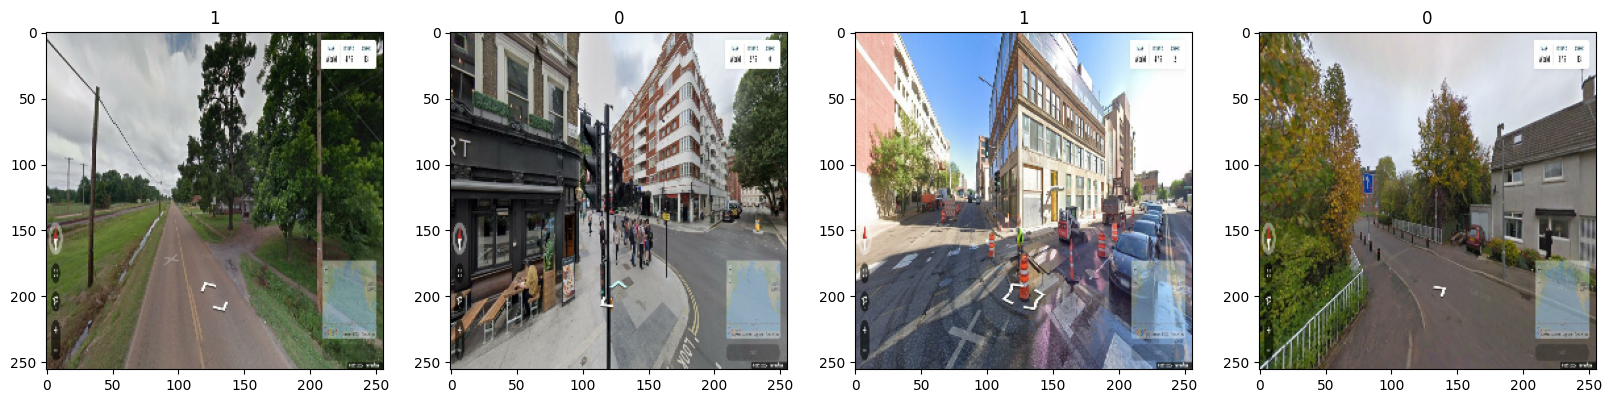

In [10]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [11]:
data = data.map(lambda x,y: (x/255, y))

data.as_numpy_iterator().next()

(array([[[[0.5533471 , 0.58471966, 0.59648436],
          [0.5294118 , 0.56078434, 0.57254905],
          [0.5411765 , 0.57254905, 0.58431375],
          ...,
          [0.66233915, 0.681947  , 0.6937117 ],
          [0.6780254 , 0.69763327, 0.709398  ],
          [0.6862745 , 0.7058824 , 0.7176471 ]],
 
         [[0.5711244 , 0.6024969 , 0.6142616 ],
          [0.5387408 , 0.57011336, 0.58187807],
          [0.5318474 , 0.56321996, 0.57498467],
          ...,
          [0.6681526 , 0.6877604 , 0.6995251 ],
          [0.68383884, 0.7034467 , 0.7152114 ],
          [0.6928998 , 0.71250767, 0.7242724 ]],
 
         [[0.5728937 , 0.6042662 , 0.61603093],
          [0.5469899 , 0.57836246, 0.59012717],
          [0.5235984 , 0.5549709 , 0.5667356 ],
          ...,
          [0.6764017 , 0.6960095 , 0.7077742 ],
          [0.69012713, 0.709735  , 0.7214997 ],
          [0.6999311 , 0.7195389 , 0.73130363]],
 
         ...,
 
         [[0.435432  , 0.43529412, 0.40433517],
          [0.43123

In [13]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [14]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [16]:
# the real work starts here

model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
logdir='logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# lower epoch for faster training, higher for better results
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 289ms/step - accuracy: 0.5694 - loss: 0.6847 - val_accuracy: 0.6250 - val_loss: 0.6662
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 317ms/step - accuracy: 0.5795 - loss: 0.6834 - val_accuracy: 0.6094 - val_loss: 0.6717
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 293ms/step - accuracy: 0.5794 - loss: 0.6805 - val_accuracy: 0.6058 - val_loss: 0.6691
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 296ms/step - accuracy: 0.5790 - loss: 0.6766 - val_accuracy: 0.7067 - val_loss: 0.5974
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 276ms/step - accuracy: 0.6947 - loss: 0.6014 - val_accuracy: 0.7055 - val_loss: 0.5777
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 30s 321ms/step - accuracy: 0.6894 - loss: 0.5950 - val_accuracy: 0.7224 - val_loss: 0.5590
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 335ms/step - accuracy: 0.7001 - loss: 0.5909 - val_accuracy: 0.7224 - val_loss: 0.5434
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 312ms/step - accuracy: 0.7022 - loss: 0.5800 - val_accu

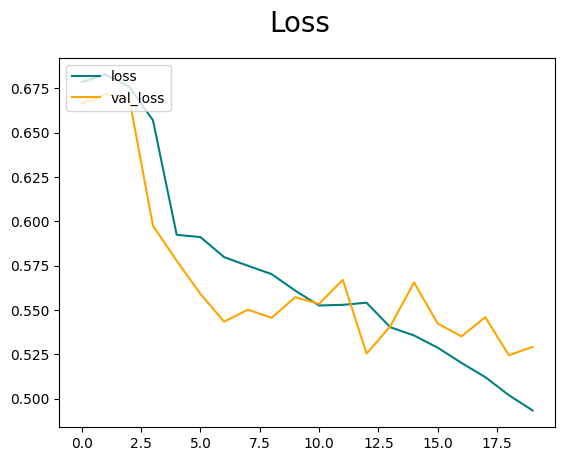

In [21]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

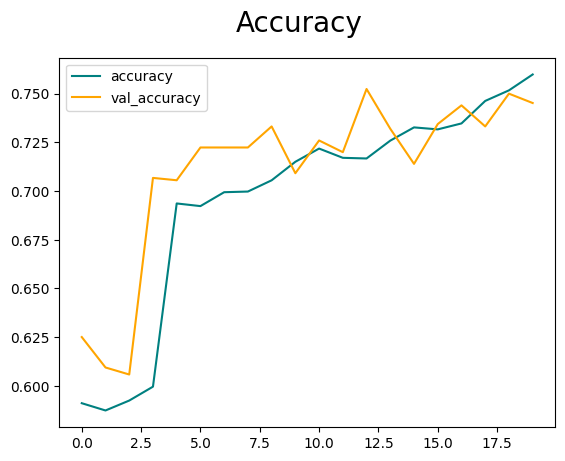

In [22]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [23]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [24]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(pre.result(), re.result(), acc.result())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
tf.Tensor(0.6923077, shape=(), dtype=float32) tf.Tensor(0.5869565, shape=(), dtype=float32) tf.Tensor(0.7019231, shape=(), dtype=float32)


2025-04-25 23:39:12.438512: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# test

img = cv2.imread('IMG_NAME.jpg')
resize = tf.image.resize(img, (256,256))
yhat = model.predict(np.expand_dims(resize/255, 0))

if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

In [ ]:
# export model

model.save(os.path.join('models','geoguesser.h5'))

In [ ]:
new_model = load_model('geoguesser.h5')
new_model.predict(np.expand_dims(resize/255, 0))